In [27]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from umap import umap_
from sklearn.metrics import silhouette_score
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import lightgbm as lgb
import shap

C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
---

# CLEANING

---

### DESCRIBE

In [15]:
df = pd.read_csv('data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [16]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

---

### DUMMIFY

In [18]:
to_replace = {
    'No' : 0,
    'Yes': 1
}

for c in ['Partner','Dependents','PhoneService', 'PaperlessBilling', 'Churn']:
    df[c] = df[c].map(to_replace)

In [19]:
to_replace = {
    'Female' : 0,
    'Male' : 1
}

df['gender'] = df['gender'].map(to_replace)

In [20]:
to_replace = {
    'No phone service': 0,
    'No': 1,
    'Yes': 2
}

df['MultipleLines'] = df['MultipleLines'].map(to_replace)

In [21]:
to_replace = {
    'DSL' : 1,
    'Fiber optic': 2,
    'No' : 0
}

df['InternetService'] = df['InternetService'].map(to_replace)

In [22]:
to_replace = {
    'No' : 0,
    'Yes': 1,
    'No internet service' : 0
}

for c in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[c] = df[c].map(to_replace)

In [23]:
to_replace = {
    'Month-to-month': 0,
    'One year': 1,
    'Two year': 2
}

df['Contract'] = df['Contract'].map(to_replace)

In [25]:
df = pd.get_dummies(df, columns=['PaymentMethod'], prefix='PaymentMethod', drop_first=True, dtype=int)

---

### DIMENSIONAL REDUCTION AND CLUSTER

In [69]:
features = df.select_dtypes(include=['number'])

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

umap_reducer = umap_.UMAP(n_components=3, random_state=42)
umap_data = umap_reducer.fit_transform(normalized_data)

C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [70]:
dict_umap = { 
    'UMAP1' : umap_data[:,0],
    'UMAP2' : umap_data[:,1],
    'UMAP3' : umap_data[:,2],
    'churn' : df['Churn']
    }

df_umap = pd.DataFrame(dict_umap)

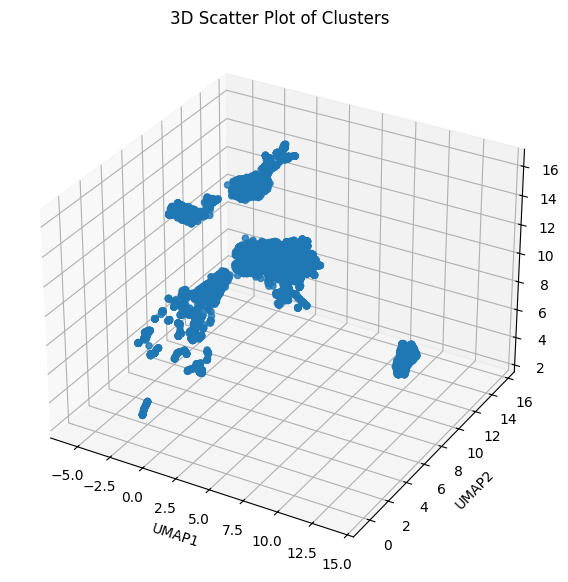

In [78]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_umap['UMAP1']  
y = df_umap['UMAP2']  
z = df_umap['UMAP3']

# Create the scatter plot
scatter = ax.scatter(x, y, z, s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.show()


In [72]:
clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clustering.fit_predict(df_umap[['UMAP1','UMAP2','UMAP3']])

df_umap['cluster'] = clustering.labels_

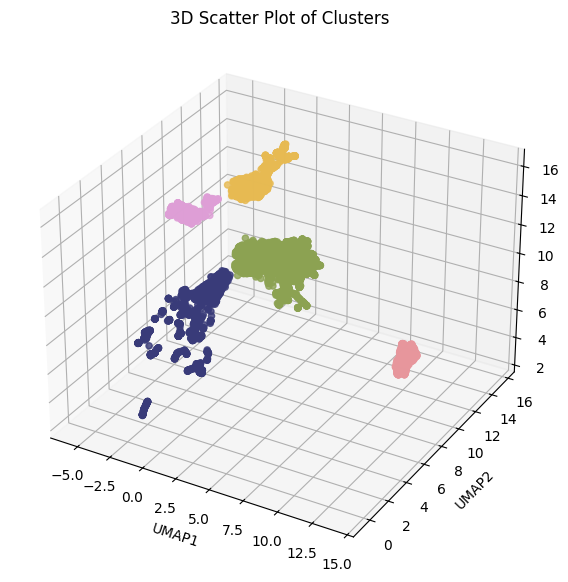

In [79]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_umap['UMAP1']  
y = df_umap['UMAP2']  
z = df_umap['UMAP3']  
labels = df_umap['cluster']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20b', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.show()


In [81]:


X = features
y = df_umap['cluster'].astype(str)

# We create the LGBMClassifier model and train it
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf_km.fit(X=X, y=y)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 7043, number of used features: 21
[LightGBM] [Info] Start training from score -1.590173
[LightGBM] [Info] Start training from score -0.918138
[LightGBM] [Info] Start training from score -1.783136
[LightGBM] [Info] Start training from score -2.334760
[LightGBM] [Info] Start training from score -2.025681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier(colsample_by_tree=0.8)

In [82]:
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km(X)

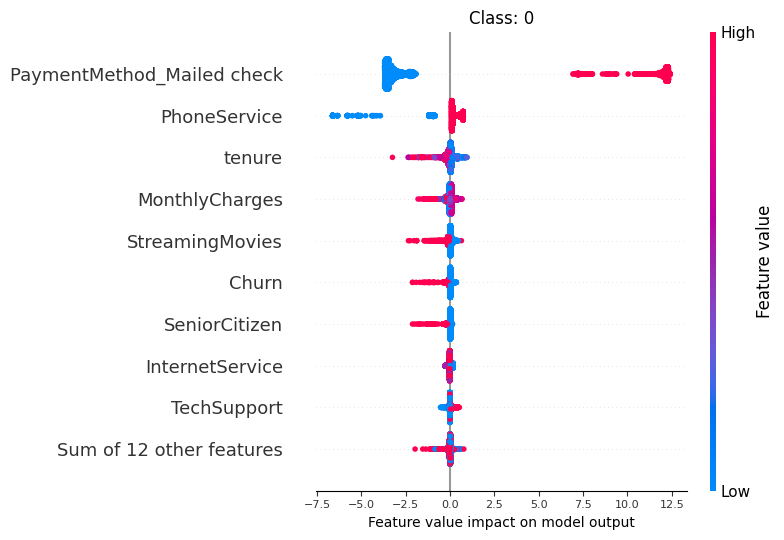

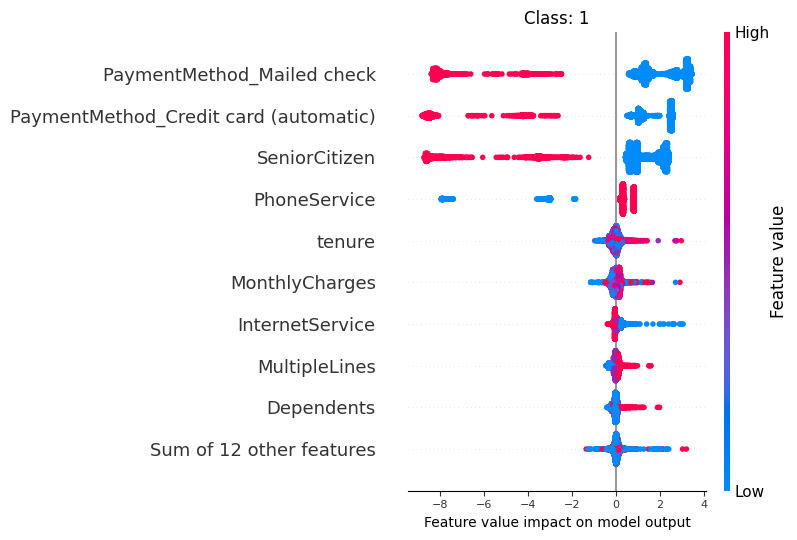

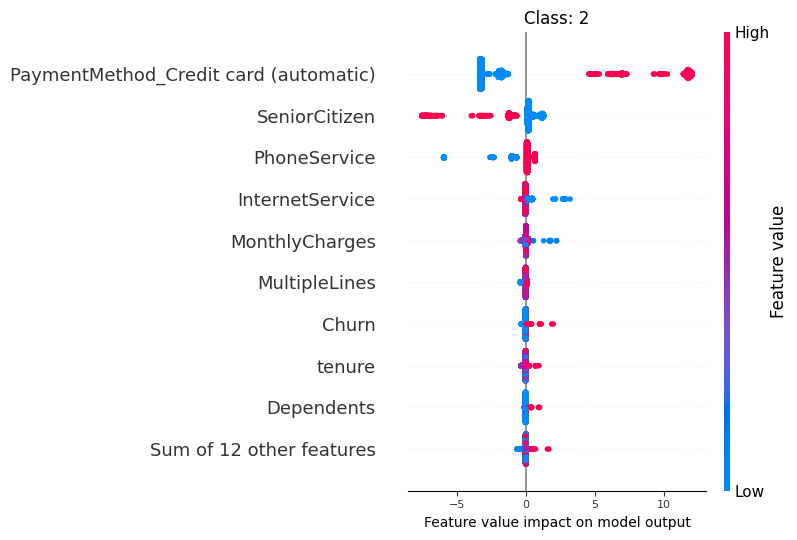

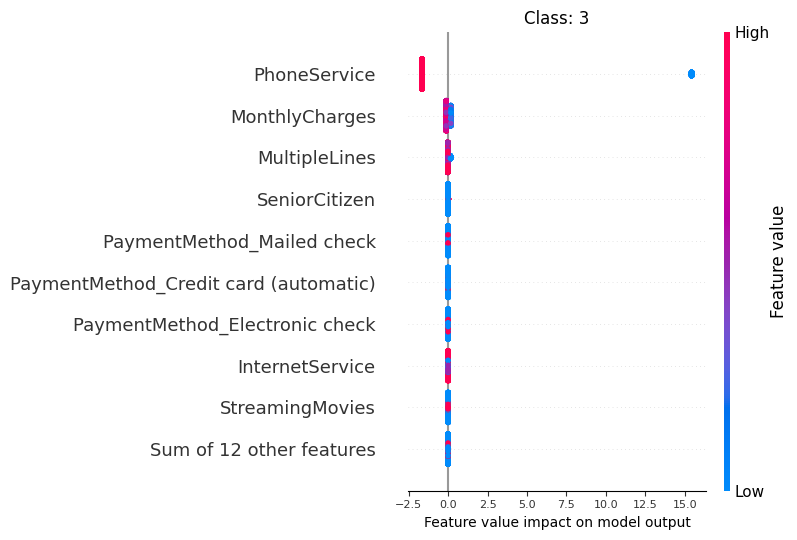

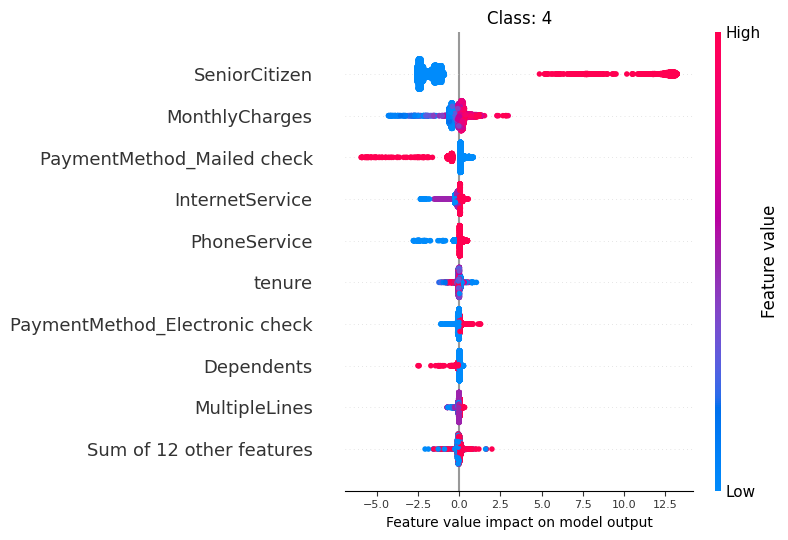

In [88]:
class_names = clf_km.classes_

for k in range(5):
    shap.plots.beeswarm(shap_values_km[:, :, k], show=False)
    ax = plt.gca()
    ax.set_title(f"Class: {class_names[k]}")

    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel("Feature value impact on model output", fontsize=10)
    plt.tight_layout()
    plt.show()


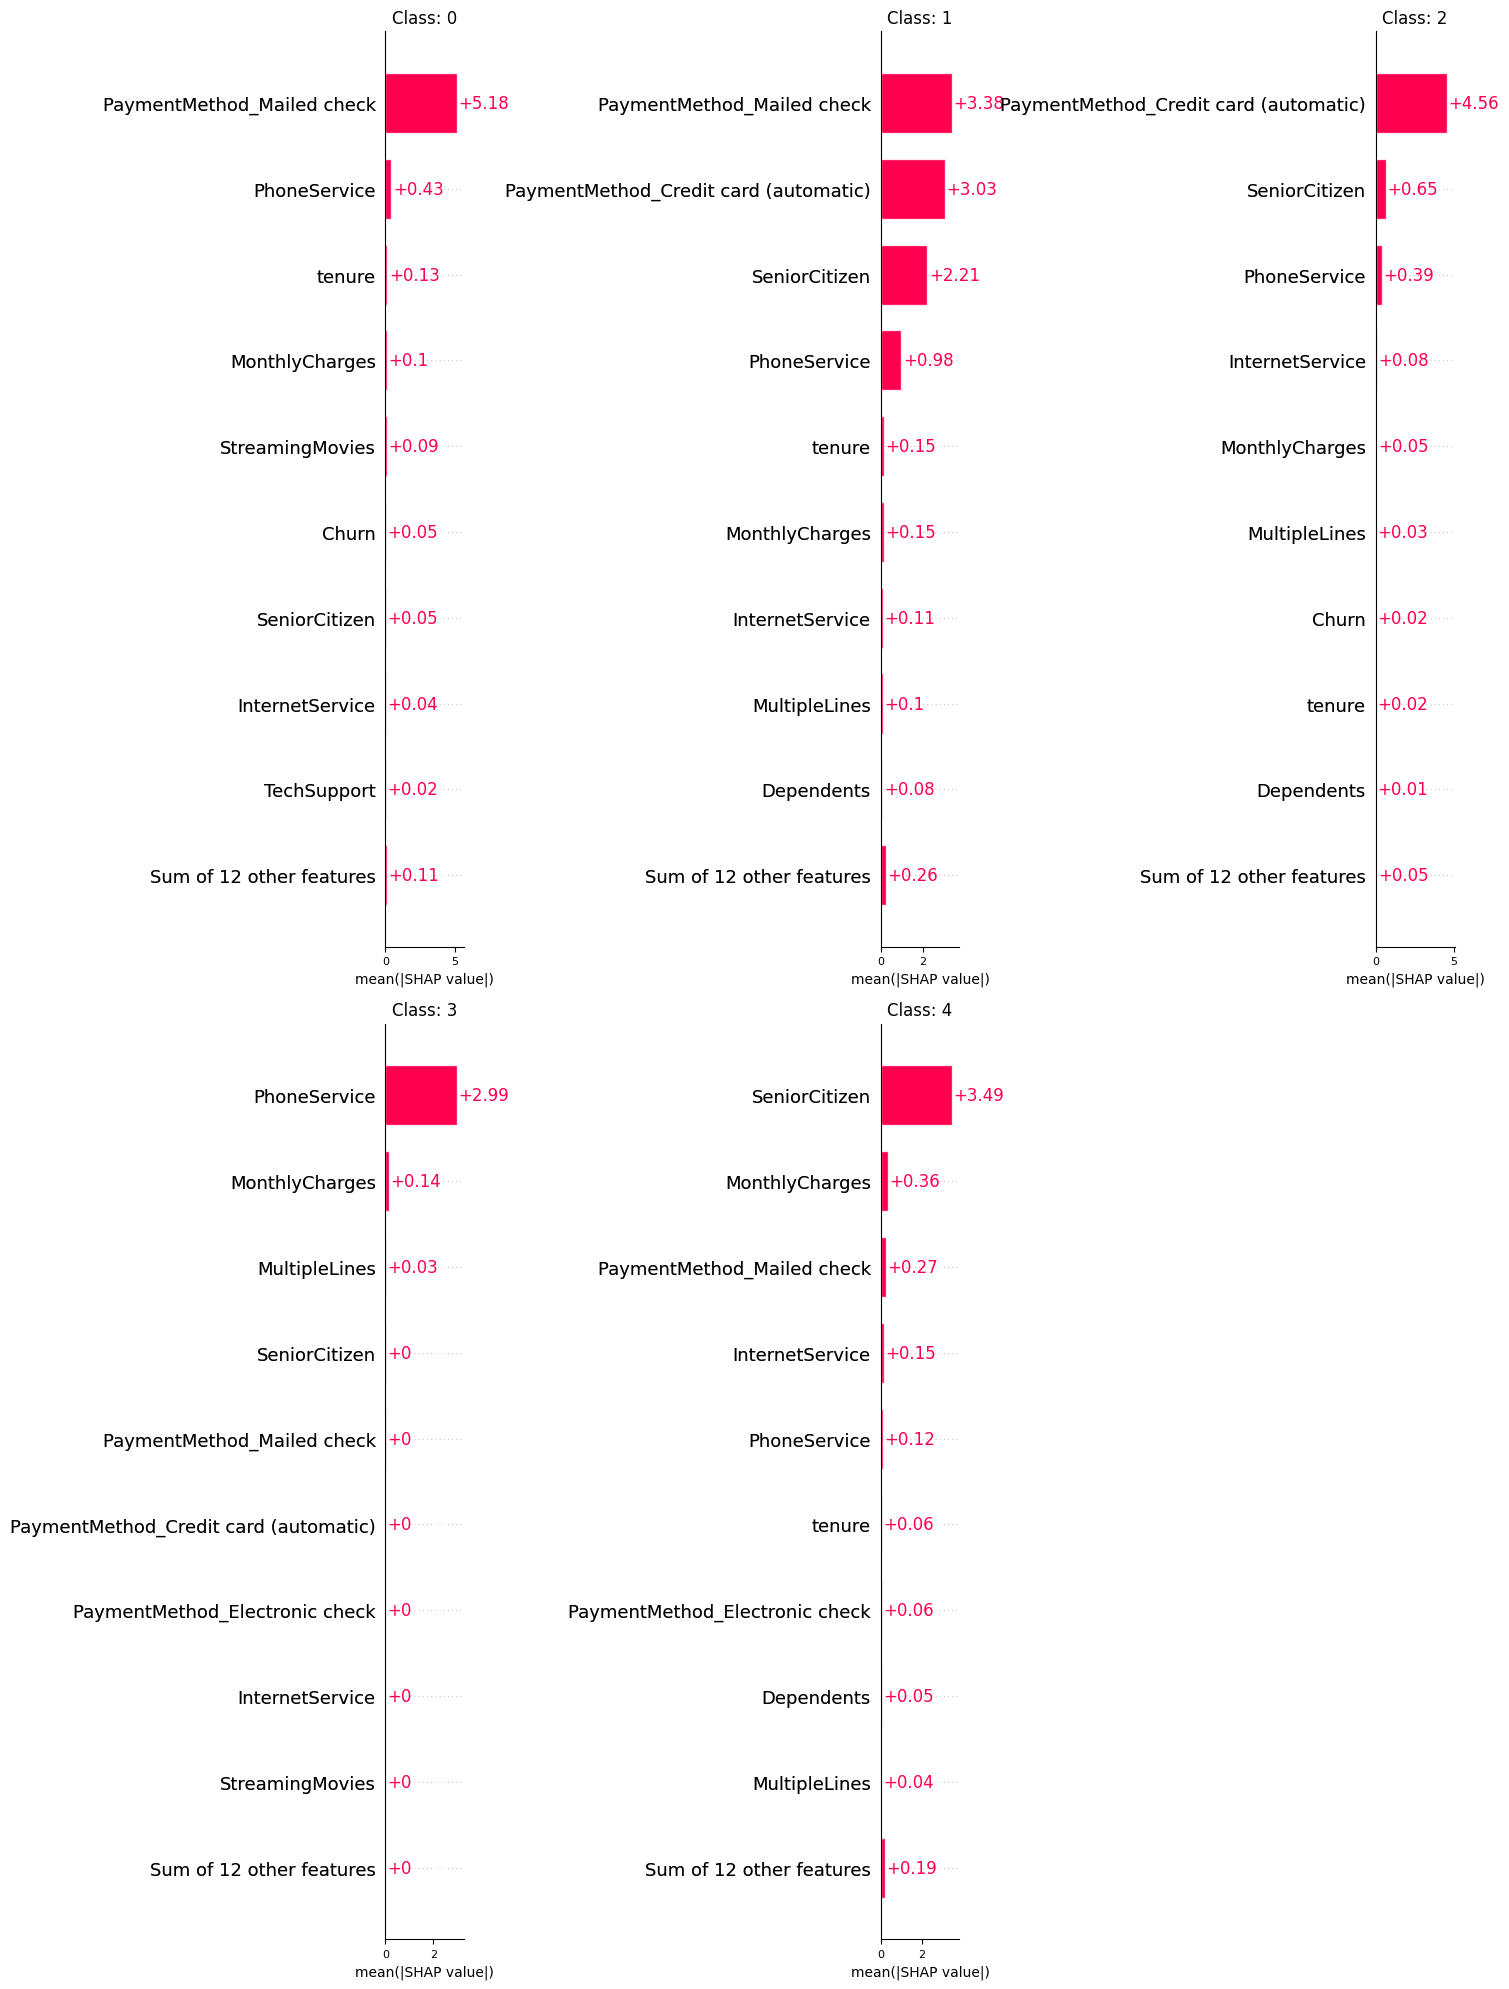

In [83]:
class_names = clf_km.classes_ 

fig, axes = plt.subplots(2, 3, figsize=(15, 20))  # Adjust figsize for readability
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < len(class_names):
        shap.plots.bar(shap_values_km[:, :, k], show=False, ax=ax)
        ax.set_title(f"Class: {class_names[k]}")

        ax.tick_params(axis='x', labelsize=8)
        ax.set_xlabel("mean(|SHAP value|)", fontsize=10)
    else:
        ax.axis('off')
        
plt.tight_layout()
plt.savefig('artifacts/imgs/shap.png', transparent=True, bbox_inches='tight')
plt.show()


In [94]:
features['cluster'] = df_umap['cluster']

cluster_names = {
    '0' : 'mail check payers',
    '1' : 'senior bank transfer payers',
    '2' : 'young credit card users',
    '3' : 'no phone service',
    '4' : 'senior high spenders'
}

features['cluster_name'] = features['cluster'].astype(str).replace(cluster_names)
df_umap['cluster_name'] = features['cluster_name']

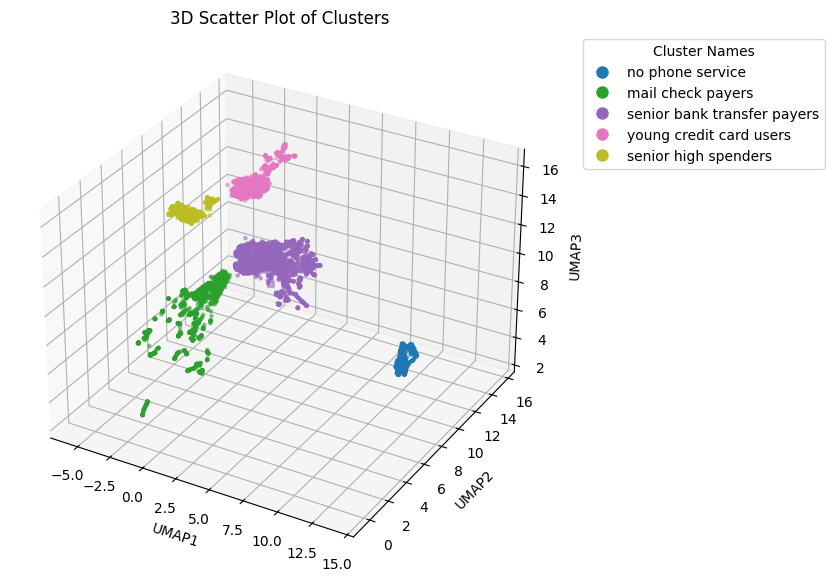

In [95]:
# Assuming df_sampled is already defined and contains the necessary columns
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_umap['UMAP1']  
y = df_umap['UMAP2']  
z = df_umap['UMAP3']  
labels = df_umap['cluster']  # This contains the cluster number for each point
cluster_names = df_umap['cluster_name'].unique()  # Extract unique cluster names

# Use the same colormap
cmap = plt.cm.tab20

# Plot each cluster separately
handles = []
for i, cluster_name in enumerate(cluster_names):
    # Filter the data for the current cluster
    cluster_data = df_umap[df_umap['cluster_name'] == cluster_name]
    
    # Assign a specific color to the cluster
    color = cmap((i) / len(cluster_names))
    
    # Plot the cluster points
    ax.scatter(
        cluster_data['UMAP1'], 
        cluster_data['UMAP2'], 
        cluster_data['UMAP3'], 
        c=[color], 
        label=cluster_name, 
        s=5, 
        alpha=0.5
    )
    
    # Add to legend handles
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cluster_name)
    handles.append(handle)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Add the legend with the custom handles
ax.legend(handles=handles, title="Cluster Names", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save and show the plot
plt.savefig('artifacts/imgs/clustering.png', transparent=True, bbox_inches='tight')
plt.show()

---
---

# CHURN PREDICTION